# Homework 1

### MATH-GA 2805 Trends in Sell-Side Modelling
**Lavaneesh Sharma (lss8875)** \
**Abhishek Kulkarni (ask 9103)**

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy import optimize
from scipy.optimize import minimize
from scipy.stats import norm

# Problem 1 
## Question 1

Consider a world with only 3 ratings: Good ($G$), Bad ($B$), and Default ($D$).
Credit rating migration is assumed described by a time-homogenous Markov
chain with transition matrix $M$. Over a period of $0.25$ years, the risk-neutral
transition matrix has been estimated to be

$$ M(0.25) =  \begin{bmatrix} 
a & b & c \\ 
d & e & f \\ 
g & h & i \\
\end{bmatrix} 
$$

for certain positive constants $a, b, ..., i$. Let us consider the probability of defaulting over a period of $0.5$ years, starting in either state $G$ or state $B$. Write
these two probabilities as a function of only $b, c, e, and f$.

Multiplying the two matrices we get $$ M(0.5) = 
\begin{equation*}
  \begin{bmatrix}
a & b & c \\ 
d & e & f \\ 
0 & 0 & 1 \\
  \end{bmatrix}
  \begin{matrix}
      \begin{bmatrix}
a & b & c \\ 
d & e & f \\ 
0 & 0 & 1 \\
   \end{bmatrix}
\end{matrix}
\end{equation*}
$$

$$ = \begin{bmatrix}
{a^2} + bd & ab+be & ac+bf+c \\ 
ad+de & bd+{e^2} & dc+ef+f \\ 
0 & 0 & 1 \\
 \end{bmatrix}
 $$

From the theory of transition matrices, in matrix $M(0.25)$ we know that

<center> $a+b+c=1$ </center>
<center> $\therefore a = 1 -(b+c)$ </center>

<center> $d+e+f=1$ </center>
<center> $\therefore d = 1 -(e+f)$ </center>

<center> $\therefore P(X_{f}=D | X_{i}=G) = c(2-c) + b(f-c)$ </center>

<center> $\therefore P(X_{f}=D | X_{i}=B) = c(1-f)-e(c-f)+f$ </center>

*******

## Question 2
Let $ c = 0.25\%, b = 0.75\%, f = 3.50\%, e = 94.75\% $. 

Compute the $0.5$-year default probability when starting in state $G$, using the result in question 1
above. 

Find the same result when starting in state $B$.

In [2]:
c = 0.0025
b = 0.0075
f = 0.035
e = 0.9475

Using the results obtained above, we get

In [3]:
Prob_G_to_D = c*(2-c) + b*(f-c)
print(f"Probability of default starting in state G = {Prob_G_to_D}")

Probability of default starting in state G = 0.0052375


In [4]:
Prob_B_to_D = c*(1-f) - e*(c-f) + f
print(f"Probability of default starting in state B = {Prob_B_to_D}")

Probability of default starting in state B = 0.06820625


We can also verify our result by raising the matrix $M$ to power $2$

In [5]:
mat = np.array([[1-(b+c), b, c],[1-(e+f), e, f],[0,0,1]])

We define a function **Markov** that takes in a matrix and an integer (no of times it is to be raised to) to calculate higher powers of any matrix.

In [6]:
def Markov(n,matrix):
    X = matrix
    for i in range(n):
        X = np.matmul(X,matrix)
    return X

In [7]:
print("Default Probability when starting in state G", np.round(Markov(1,mat)[0][-1],7))
print("Default Probability when starting in state B", np.round(Markov(1,mat)[1][-1],8))

Default Probability when starting in state G 0.0052375
Default Probability when starting in state B 0.06820625


**These are the same values we get when solving for the probabilities using the expressions derived earlier!**

*****

## Question 3 
 Consider now a $6$-year risky coupon bond paying a promised coupon of $5\%$
annually until maturity. 

The underlying firm’s credit quality can be assumed to be described by the transition matrix in question 1, with the parameters from question 2. 

If the underlying firm defaults, the bond vanishes with no recovery at the time of default; should the bond survive until maturity a notional of $\$100$ will be paid on the bond. Compute the price of this bond. 

Please consider all three cases of the initial state of the firm $(G, B, \& D)$. The risk-free
(continuously compounded) interest rate is constant at $2\%$.

In [8]:
# Bond Price

def PVCF(rfr, coupon, n, state):
    
    PV_coupon = 0
    
    for i in range(n-1):
        
        if state == 'Good':
            PV_coupon += coupon*np.exp(-rfr*(i))*(1-Markov(i,Markov(3,mat))[0][2])
            #print(PV,"*****",1-Markov(i,Markov(3,mat))[0][2])
            Final_value = (100+coupon)*np.exp(-rfr*n)*(1-Markov(n-1,Markov(3,mat))[0][2])
        
        elif state == 'Bad':
            PV_coupon += coupon*np.exp(-rfr*(i))*(1-Markov(i,Markov(3,mat))[1][2])
            #print(PV,"*****",1-Markov(i,Markov(3,mat))[1][2])
            Final_value = (100+coupon)*np.exp(-rfr*n)*(1-Markov(n-1,Markov(3,mat))[1][2])
    
    return PV_coupon + Final_value

In [9]:
print("Bond Value Starting in Good State = ", PVCF(0.02,5,6,"Good"))
print("Bond Value Starting in Bad State = ", PVCF(0.02,5,6,"Bad"))

Bond Value Starting in Good State =  106.6794612047598
Bond Value Starting in Bad State =  63.61863630799728


*****

## Question 4
In the setting of Q3, let $X(0, T)$ be the survival probability as a function of the
horizon $T$

Define a term hazard rate as $X(0, T) = e^{\frac{-\hat{\lambda}(T)}{T}}$ . Graph $\lambda(T)$ for the initial states $G$ and $B$. 

Explain (in words) why the two curves have slopes of opposite sign.

In [10]:
# Hazard Rate Function

def Lambda(n, state):
    
    res = []
    
    if state == "Good":
        for i in range(n):
            res.append(-np.log((1-Markov(i,Markov(3,mat))[0][2]))/(i+1))
    
    if state == "Bad":       
        for i in range(n):
            res.append(-np.log((1-Markov(i,Markov(3,mat))[1][2]))/(i+1))
    
    return res

Text(0, 0.5, 'Hazard Rate λ')

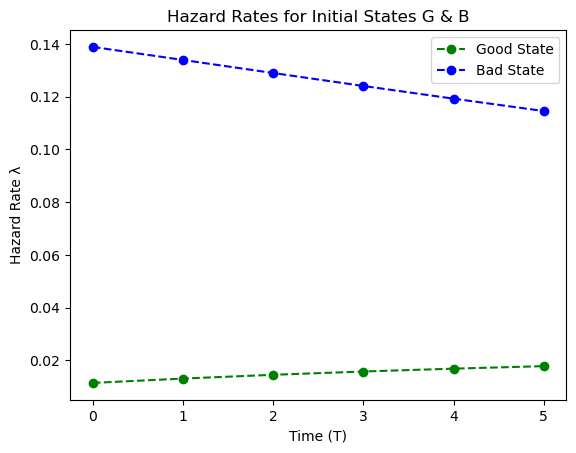

In [11]:
plt.plot(Lambda(6,"Good"),"go--",label = "Good State")
plt.plot(Lambda(6,"Bad"),"bo--",label = "Bad State")
plt.legend()
plt.title("Hazard Rates for Initial States G & B")
plt.xlabel('Time (T)')
plt.ylabel('Hazard Rate \u03BB')

#### If the firm starts in a bad state, it has chance/likelihood of improving upon its current state of (B), hence lambda decreases with time. If the firm starts in a Good State (G) it is essentially the best state the firm can start at and there is little chance for firm to go better than (G). 

*******

## Question 5
We now extend our transition matrix to include a new state: Medium $(M)$. We consider the transition matrix:

 States | G | M | B | D |
  --- | --- | --- | --- | --- |
**G** | 97% | 1.5% | 1% | 0.5% |
**M** | 1% | 96% | 1.75% | 1.25% |
**B** | 1% | 1.6% | 93.5% | 3.9% |
**D** | 0% | 0% | 0% | 100% |

Assume now that our reference firm starts in state $G$. We enter into a security where we will receive $\$1$ at time $T = 2.5$, if the firm does not default before then. 

Let the interest rate be constant at $2\%$, as before.

What is the price of this security?

In [12]:
mat2 = [[.97,0.015,0.01,0.005],[0.01,0.96,0.0175,0.0125],[0.01,0.016,.9350,0.039],[0,0,0,1]]

In [13]:
conditional_PVCF = 1*(1-Markov(9,mat2)[0][-1])*np.exp(-0.02*2.5)
print(f"Price of the security = {conditional_PVCF}")

Price of the security = 0.8886960113811696


******

## Question 6

We now add a downgrade protection clause to the security defined in question 5 above. Specifically, if the firm reaches state $B$, we will be given a $\$1$ risk-free discount bond maturing at time $T = 2.5$, and the trade will terminate. We assume that the downgrade clause is checked every $0.25$ years. 

What is now the price of the security in question 5?

(Hint: consider cleverly modifying the transition matrix to introduce an absorbing state somewhere). 

Compare to the result in question 5.

In [14]:
mat3 = [[.97,0.015,0.01,0.005],[0.01,0.96,0.0175,0.0125],[0,0,0,0],[0,0,0,1]]

In [15]:
def DowngradeProtection(n,mat,Payoff):
    PV = 0
    for i in range(n):
        PV += Payoff*Markov(i,mat)[0][2]
        
    return PV + (1-Markov(n-1,mat3)[0][-1])*Payoff*np.exp(-0.02*2.5)

In [16]:
print(f"Price of the security = {DowngradeProtection(10,mat3,1)}")

Price of the security = 1.0003492932749507


In [17]:
print("Price of the security is greater than its price in Q5 by ",  
      np.round(DowngradeProtection(10,mat3,1)-conditional_PVCF, 4))

Price of the security is greater than its price in Q5 by  0.1117


********

# Problem 2

## Question 1
Consider a standard Merton model for a firm with equity $E(0) = \$10 $ and face value of debt $ D_{F} = \$10 $. 
Let the risk-free continuously compounded interest rate be $r = 2\%$, and assume that the asset volatility ($\sigma_{A}$) has been estimated at $30\%$.

On a $5-$year horizon, what is the time $0$ fair price of - \
a) the firm’s assets and \
b) the firm’s debt? \
c) what is the survival probability of the firm?

In [18]:
# Inputs

E0 = 10
Df = 10
r = 0.02
sigA = 0.3
T = 5

In [19]:
def asset_val(a):
    
    d_plus = (np.log(a/Df) + (r + 0.5*sigA**2)*T)/(sigA*np.sqrt(T))
    d_minus = (np.log(a/Df) + (r - 0.5*sigA**2)*T)/(sigA*np.sqrt(T))
    
    return a*norm.cdf(d_plus) - Df*np.exp(-1*r*T)*norm.cdf(d_minus) - E0

In [20]:
A0 = optimize.newton(asset_val, 1)
print(f"Time 0 fair price of firm's assets A0 = {A0}")

Time 0 fair price of firm's assets A0 = 18.42882658967022


In [21]:
D0 = A0 - E0
print(f"Time 0 fair price of firm's debt D0 = {D0}")

Time 0 fair price of firm's debt D0 = 8.42882658967022


In [22]:
#Survival Probability

def survival_prob1(A,D,sig,r,T):
    
    return 1 - norm.cdf(-(np.log(A/D) + (r - 0.5*sig**2)*T)/(sig*np.sqrt(T)))

In [23]:
survival_probability1 = survival_prob1(A0,Df,sigA,r,T)
print(f"Survival probability of the firm = {survival_probability1}")

Survival probability of the firm = 0.7657676850600381


*****

## Question 2

Now consider an extended (continuous-barrier) Merton model, where the assets have drift $\mu = r$, and parameters (including the initial asset value) are otherwise as in question 1. 

What is the $5-$year survival probability in this model, assuming that the default barrier $H$ is set equal to $D_{F}$? 

Is this higher or lower than that in question 1? Explain.

In [24]:
def survival_prob2(t, H, A):
    
    a = r - 0.5*(sigA**2)
    h = np.log(H/A)
    
    return 1 - (norm.cdf((h-a*t)/(sigA*np.sqrt(t))) +  
                np.exp(2*a*h/(sigA**2)) * norm.cdf((a*t + h)/(sigA * np.sqrt(t))))

In [25]:
survival_probability2 = survival_prob2(T, Df, A0)
print(f"Survival probability of the firm = {survival_probability2}")

Survival probability of the firm = 0.5745171658288526


**As seen above, the survival probability of the firm decreases when we use the continuous barrier extension of the Merton model. This is essentially a consequence of the fact that defaults generated by diffusion processes are “predictable” with slowly deteriorating firm assets, rather than “surprising”.**

*****

## Question 3

Using the model in question $2$ compute survival probabilities on a grid of maturities $\{0.1, 0.25, 0.5, 1, 2, 3, 5, 7, 10\}$. 

If $X(0,T)$ is the survival probability to time $T$, define (as we did earlier) a term-hazard rate function $\hat{\lambda}(T)$ as $X(0,T) = e^{−\hat{\lambda}(T).T}$. From your results, show a graph of the function $\hat{\lambda}(T)$. 

Can you formally establish the limit $\lim_{T \to 0} \hat{\lambda}(T)$ ?

In [26]:
maturity_grid = [0.1, 0.25, 0.5, 1, 2, 3, 5, 7, 10]

survival_prob = []

for i in maturity_grid:
    survival_prob.append(survival_prob2(i, H=10, A=A0))

survival_prob

[0.9999999998621385,
 0.9999456382534775,
 0.9953215061283593,
 0.9508609873811963,
 0.8234952740165817,
 0.7180036237769543,
 0.5745171658288526,
 0.48274602708523107,
 0.3928038429188093]

Text(0, 0.5, 'Survival Probability')

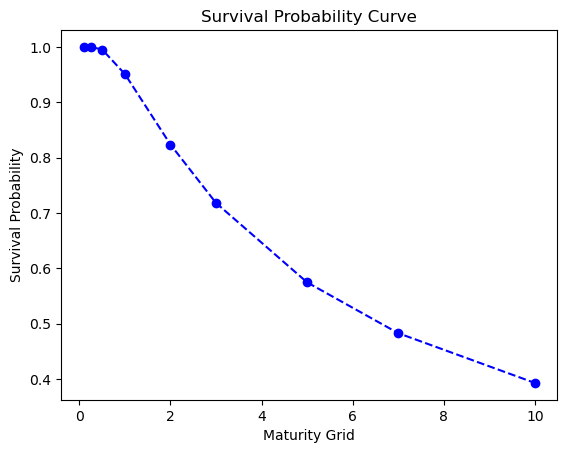

In [27]:
plt.plot(maturity_grid, survival_prob, 'bo--')
plt.title("Survival Probability Curve")
plt.xlabel('Maturity Grid')
plt.ylabel('Survival Probability')

In [28]:
def hazard_rate_func(mg, sp):
    return (-np.log(sp))/mg

<center>Hazard Rate ($\hat{\lambda}(T)$) =  $-\frac{\ln(X(0,T))}{T}$ </center>

In [29]:
lambdas = []

for i in range(len(maturity_grid)):
    lambdas.append(hazard_rate_func(maturity_grid[i], survival_prob[i]))

lambdas

[1.3786150000312186e-09,
 0.0002174528967032314,
 0.009378944558170904,
 0.05038740232517247,
 0.09709873414001051,
 0.11042688763451246,
 0.11084506050841167,
 0.1040377982090717,
 0.09344449191514927]

Text(0.5, 1.0, 'Lambda as a function of T')

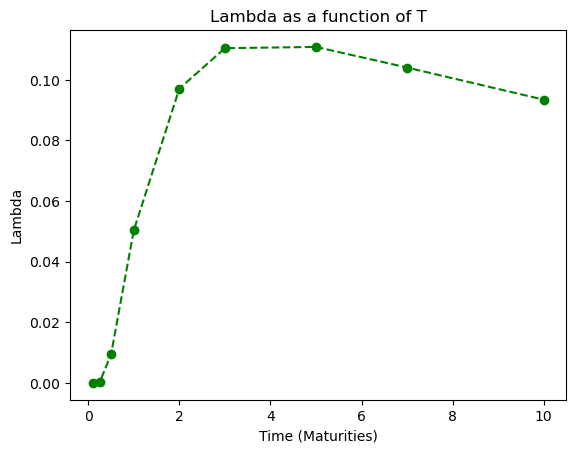

In [30]:
plt.plot(maturity_grid, lambdas, 'go--')
plt.xlabel('Time (Maturities)')
plt.ylabel('Lambda')
plt.title('Lambda as a function of T')

**As visible from the graph above, the hazard rate function $\hat{\lambda}(T)$ increases sharply for small maturities and then falls off to its limiting value, which for our observation period of maturity 10 yrs is close to 0.07** 

**The formal limit of the hazard rate function is derived below,**

We know that, 

<center> $\hat{\lambda}(T) = -\frac{\ln(X(0,T))}{T}$ </center> 

where, 

$$X(0,T) = 1 - P(\tau < T)$$ 

$$ \therefore X(0,T) = 1 \; - \; \phi \left( \frac{h-at}{\sigma_{A}\sqrt{T}} \right) \; - \; e^{\frac{2ah}{\sigma_{A}^{2}}} \; \phi \left( \frac{h+at}{\sigma_{A}\sqrt{T}} \right)$$

Applying limits,

$$\lim_{T \to 0} X(0,T) = \lim_{T \to 0} \left[ 1 \; - \; \phi \left( \frac{h-at}{\sigma_{A}\sqrt{T}} \right) \; - \; e^{\frac{2ah}{\sigma_{A}^{2}}} \; \phi \left( \frac{h+at}{\sigma_{A}\sqrt{T}} \right) \right]$$

<center> As $T \to 0$, </center>

<center>$\phi \left( \frac{h-at}{\sigma_{A}\sqrt{T}} \right) \to 0$</center>

<center> $\& \; \; \phi \left( \frac{h+at}{\sigma_{A}\sqrt{T}} \right) \to 0 $</center>

$$\therefore \lim_{T \to 0} X(0,T) = 1$$

$$\therefore \lim_{T \to 0} \hat{\lambda}(T) = \lim_{T \to 0} \frac{\ln(1)}{T} = \frac{0}{T} = 0$$

$$\therefore \lim_{T \to 0} \hat{\lambda}(T) = 0$$